# Neurodegenerative Disease Dataset


In [29]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import 3D toolkit
import matplotlib.pyplot as plt
from matplotlib import cm

### Performing PCA

In [30]:
# Load and select gene expression matrix
neuro_data = pd.read_csv('../data/neuro_dataset.csv')

# Select the expression values only
gene_expression = neuro_data.iloc[:, 6:]  # DataFrame: samples × genes

# Compute mean and variance per gene
gene_means = gene_expression.mean(axis=0)
gene_vars = gene_expression.var(axis=0)

# Compute dispersion (variance / mean)
dispersion = gene_vars / gene_means

# Bin genes by mean expression
num_bins = 20
bin_ids = pd.qcut(gene_means, q=num_bins, labels=False, duplicates='drop')

# Z-score normalization of dispersion within each bin
dispersion_norm = pd.Series(index=gene_expression.columns, dtype=float)
for b in np.unique(bin_ids):
    idx = (bin_ids == b)
    bin_disp = dispersion[idx]
    dispersion_norm[idx] = (bin_disp - bin_disp.mean()) / bin_disp.std(ddof=0)

# Select top 1500 HVGs by normalized dispersion
top_1500_genes = dispersion_norm.nlargest(1500).index
neuro_data_for_pca = gene_expression[top_1500_genes]

print("Shape of neuro_data:", neuro_data.shape)
print("Shape of neuro_data_for_pca:", neuro_data_for_pca.shape)

Shape of neuro_data: (803, 3006)
Shape of neuro_data_for_pca: (803, 1500)


In [31]:
# Mean center the data
data_centered = neuro_data_for_pca - np.mean(neuro_data_for_pca, axis=0)

# Compute Covariance Matrix (p x p)
cov_matrix = np.cov(data_centered, rowvar=False)

# Eigen Decomposition - this will be in ascending order
eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)

# Sort in descending order to rank PCs in terms of importance
sorted_idx = np.argsort(eig_vals)[::-1]
eig_vals_sorted = eig_vals[sorted_idx]
eig_vecs_sorted = eig_vecs[:, sorted_idx]

# Take the top 3 eigenvectors
top_3_eig_vecs = eig_vecs_sorted[:, :3]

# Project the original mean-centered data onto these top 3 eigenvectors
projected_data = np.dot(data_centered, top_3_eig_vecs)

### Plotting and Analysis

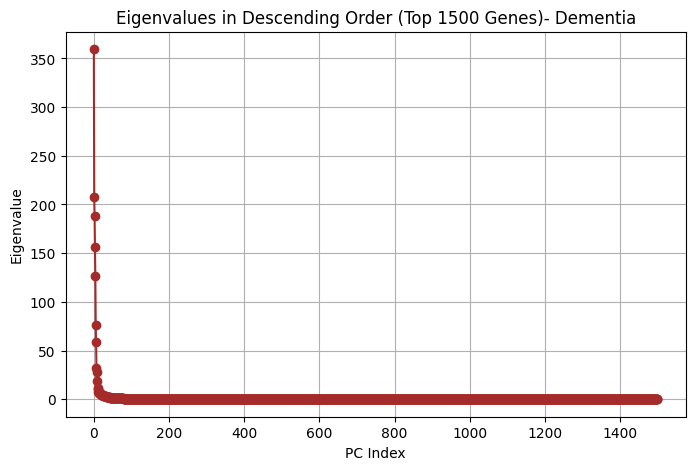

In [32]:
# Plot the eigenvalues
plt.figure(figsize=(8, 5))
plt.plot(eig_vals_sorted, marker='o', color="brown")
plt.title('Eigenvalues in Descending Order (Top 1500 Genes)- Dementia')
plt.xlabel('PC Index')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

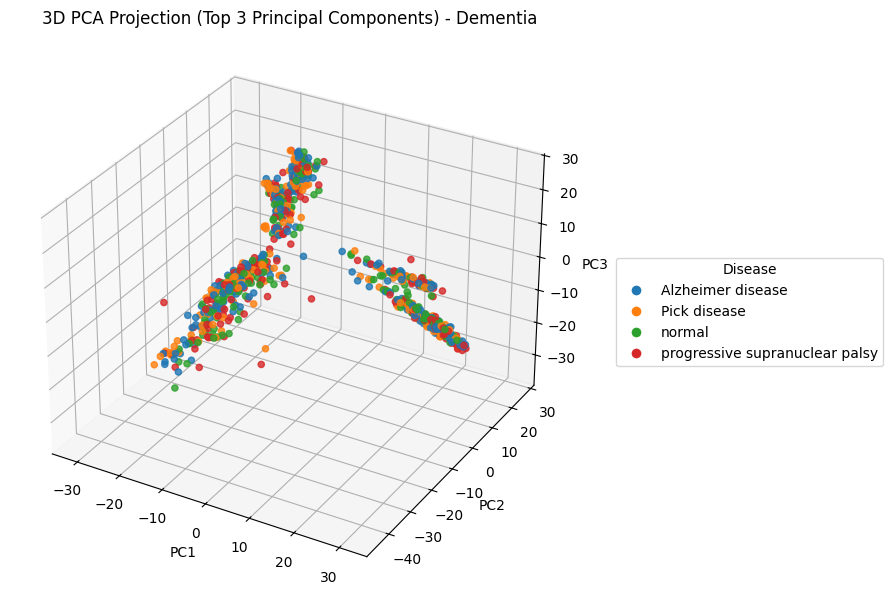

In [33]:
# Extract disease labels from the dataframe
disease = neuro_data['disease'].values

# Use 'tab10' colormap for high contrast and good differentiation
unique_labels = np.unique(disease)
colors_list = plt.get_cmap("tab10").colors  # 10 distinct, readable colors
label_to_color = {label: colors_list[i % 10] for i, label in enumerate(unique_labels)}
colors = [label_to_color[l] for l in disease]

# Create 3D PCA plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(projected_data[:, 0], projected_data[:, 1], projected_data[:, 2], 
                c=colors, alpha=0.8)

# Move legend further to the right
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_to_color[l], markersize=8)
           for l in unique_labels]
ax.legend(handles, unique_labels, title='Disease', loc='center left', bbox_to_anchor=(1.07, 0.5))

# Axis labels and title
ax.set_title('3D PCA Projection (Top 3 Principal Components) - Dementia')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Adjust layout to prevent label cutoff
plt.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.9)

plt.show()

In [34]:
# Total sum of eigenvalues (total variance)
total_var = np.sum(eig_vals_sorted)
print("Total Variance: ", total_var)

# Compute the explained variance ratio for each principal component
captured_var_ratio = eig_vals_sorted / total_var # array consisting of proportion of variance captured by individual PC

# Array of cummulative sum upto each PC in descennding order
cumulative_var = np.cumsum(captured_var_ratio)

# Number of PCs needed to capture at least 99% of the variance
num_components = np.argmax(cumulative_var >= 0.99) + 1  # 0-based indexing

# Display the number of components and the cumulative variance
print("Number of components needed to capture at least 99.0% of the variance:", num_components)
print("Cumulative variance explained by", num_components, "PCs:", f"{cumulative_var[num_components-1] * 100:.2f}%")

Total Variance:  1500.9506775442023
Number of components needed to capture at least 99.0% of the variance: 236
Cumulative variance explained by 236 PCs: 99.00%
